In [2]:
# IMPORT PACKAGES
import csv
import numpy as np
from sklearn.cluster import MeanShift# as ms
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
import pandas as pd
style.use("ggplot")
plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15 #make size of axis tick labels larger

filename = 'hopsdata1.csv' # designate filename
rawdf = pd.read_table(filename, error_bad_lines=False, delimiter = ',') #read in file
print(rawdf)


         sec  sample num    mq2    mq3    mq4    mq5    mq7  day  hop  alpha  \
0     1504.0           1  0.915  1.630  0.635  0.360  1.135    4    1   12.3   
1     1504.8           1  0.915  1.635  0.630  0.365  1.135    4    1   12.3   
2     1505.6           1  0.915  1.640  0.630  0.365  1.135    4    1   12.3   
3     1506.4           1  0.915  1.640  0.635  0.355  1.135    4    1   12.3   
4     1507.2           1  0.920  1.630  0.625  0.350  1.135    4    1   12.3   
5     1508.0           1  0.915  1.630  0.625  0.345  1.135    4    1   12.3   
6     1508.8           1  0.920  1.635  0.635  0.350  1.135    4    1   12.3   
7     1509.6           1  0.920  1.640  0.635  0.355  1.135    4    1   12.3   
8     1510.4           1  0.920  1.635  0.630  0.350  1.135    4    1   12.3   
9     1511.2           1  0.925  1.640  0.635  0.355  1.135    4    1   12.3   
10    1512.1           1  0.920  1.635  0.635  0.355  1.135    4    1   12.3   
11    1512.9           1  0.925  1.630  

In [5]:
# identify classes and input matrix
alpha = np.array(rawdf['alpha'])
beta = np.array(rawdf['beta'])

labels = np.array(rawdf['hop']) #set classes as labels

df = rawdf.filter(['mq2', 'mq4', 'mq5', 'mq7'], axis=1)

sensor = list(df) #list of sensor names
sensordata = df.values #matrix of sensor data
print(list(df))

['mq2', 'mq4', 'mq5', 'mq7']


real clusters: 5
clusters found: 5. cluster centers: 
[[ 0.57980254  0.36162906  0.21992243  0.61909027]
 [ 0.81341912  0.55485294  0.33216912  0.95819853]
 [ 0.51990909  0.31880519  0.20075325  0.53045455]
 [ 0.43301948  0.25951299  0.15746753  0.49266234]
 [ 0.93413333  0.64656667  0.36183333  1.1543    ]]


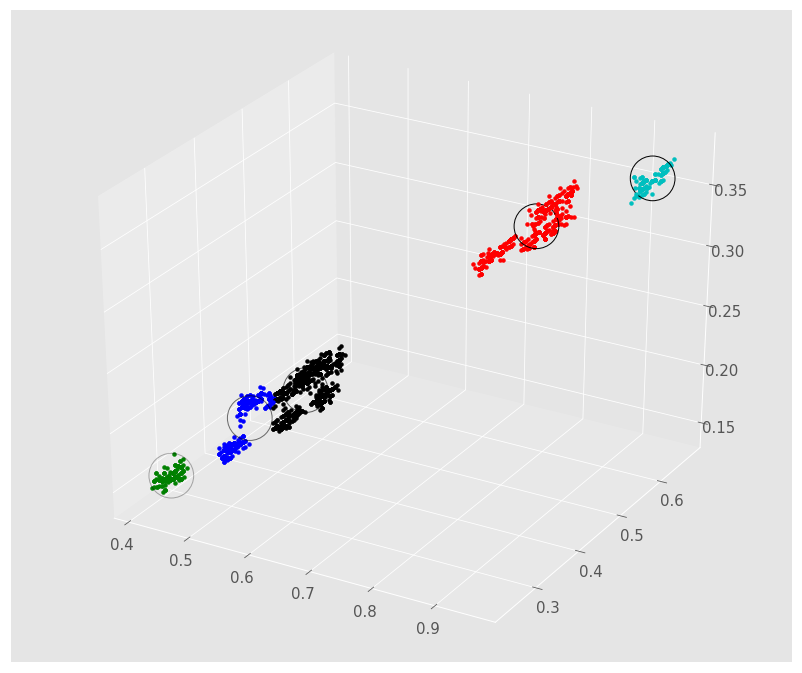

In [6]:
# IMPLEMENT MEAN SHIFT ALGORITHM
# X = input data using 3D coordinates as numpy ndarray: [[x0,y0,z0],[x1,y1,z1],...[xn,yn,zn]] 
#X, _ = make_blobs(n_samples = 100, centers = [[1,1,1],[2,1,2],[1,2,2]], cluster_std = .15)

X = sensordata

#implement mean shift algorithm & designate minimum points per bin. bandwidth = local area size to look for clusters
ms = MeanShift(min_bin_freq=2, bandwidth = 0.08) 
ms.fit(X) #find clusters
labels = ms.labels_; cluster_centers = ms.cluster_centers_

print('real clusters: ' + format(len(np.unique(labels))))
print('clusters found: ' + format(len(np.unique(labels))) + '. cluster centers: ')
print(cluster_centers)

colors = 10*['k','r','b','g','c','y','m']

fig = plt.figure(1, figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], X[i][2], s=15, c=colors[labels[i]], marker='o')
    
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], cluster_centers[:,2],
           facecolors='none', edgecolors='k', marker='o', s=2000, linewidths = 1, zorder=0)
plt.show()

In [291]:
#SAVE MEAN SHIFT RESULTS TO CSV

coords0 = np.ndarray.flatten(X) #flatten and reshape coordinate values for saving
coords0 = np.reshape(coords0, (-1,len(X[0])))

coords = np.ones((len(coords0),len(X[0])+1)) #make new matrix with coordinates and classes for saving
for i in range(len(coords)):
    coords[i][:len(X[0])] = coords0[i][0:len(X[0])]
    coords[i][len(X[0])] = labels[i]

coords = coords[coords[:,3].argsort()] #sort matrix by class number

fileheaders = ['x','y','z','label']
#open CSV file
with open('mean shift coordinates.csv', 'w') as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(fileheaders) #write headers
    for row in coords:
        writer.writerow(row)

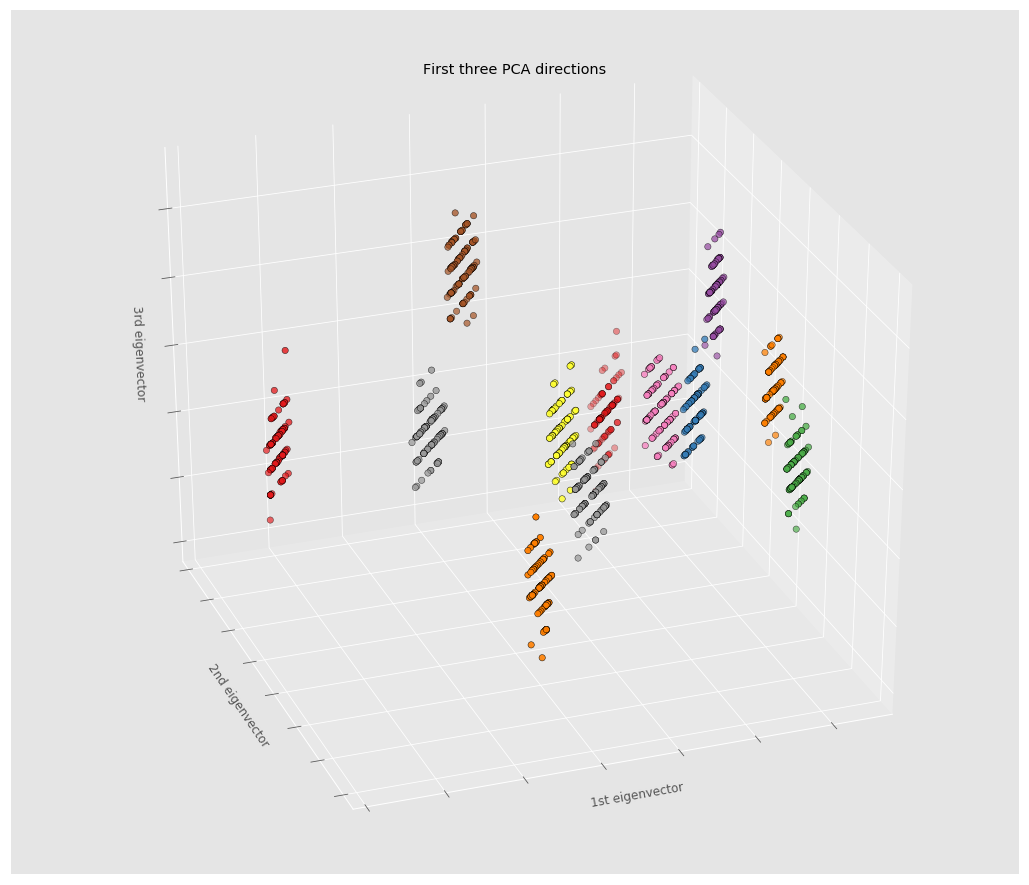

In [24]:
# PERFORM PCA
from sklearn.decomposition import PCA
#from sklearn import datasets

X_pca = PCA(n_components=3).fit_transform(X) #perform PCA

fig = plt.figure(1, figsize=(14, 12)) #set up plot
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, #plot points
           cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector"); ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector"); ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector"); ax.w_zaxis.set_ticklabels([])
plt.show()

In [293]:
#SAVE PCA RESULTS TO CSV

coords_pca0 = np.ndarray.flatten(X_pca) #flatten and reshape coordinate values for saving
coords_pca0 = np.reshape(coords_pca0, (-1,3))

coords_pca = np.ones((len(coords_pca0),4)) #make new matrix with coordinates and classes for saving
for i in range(len(coords_pca0)):
    coords_pca[i][:3] = coords_pca0[i][0:3]
    coords_pca[i][3] = labels[i]

coords_pca = coords_pca[coords_pca[:,3].argsort()] #sort matrix by class number

#open CSV file
pcafileheaders = ['pca_x', 'pca_y', 'pca_z', 'label']
with open('pca coordinates.csv', 'w') as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(pcafileheaders) #write headers
    for row in coords_pca:
        writer.writerow(row)